# Notebook 10: Recursive Forecasting (Multi-Step Ahead)

**Goal**: Implement **Recursive Forecasting** to evaluate the discrepancy between "Teacher Forcing" (using actual past values) and real-world multi-step prediction (feeding predictions back in).

**Context**: The Professor pointed out that using actual lags for 2016, 2017... (when predicting from 2015) is unrealistic. This notebook quantifies the "Error Propagation".

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error
import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('../src')))
from preprocessing import load_data

SPLIT_YEAR = 2015
TARGET = 'Value_co2_emissions_kt_by_country'
LAG_TARGET = f'{TARGET}_lag1'

# Load Best Params
with open('../data/results/best_hyperparameters.json', 'r') as f:
    best_params = json.load(f)
    
print("Loaded Best Params:", best_params)

Loaded Best Params: {'Linear Regression': {'alpha': 10.0}, 'XGBoost': {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}}


In [2]:
# Load Data
df_common = load_data('../data/processed/common_preprocessed.csv')
df_lr = load_data('../data/processed/lr_final_prep.csv')

# Load Alignment Map (Recovered via recover_sequence.py)
try:
    recovery_map = pd.read_csv('../data/processed/recovered_index_map.csv')
    print("Loaded Alignment Map.")
except FileNotFoundError:
    print("Error: Map not found. Please run recover_sequence.py")

# Ensure df_lr has RangeIndex
df_lr = df_lr.reset_index(drop=True)

if len(df_lr) == len(recovery_map):
    # Extract indices
    original_indices = recovery_map['Original_Index'].values
    
    # Assign Metadata from Common
    df_lr['Year'] = df_common.loc[original_indices, 'Year'].values
    df_lr['Entity'] = df_common.loc[original_indices, 'Entity'].values
    print("Metadata (Entity/Year) assigned via Map.")
    
    # Also align df_common support (for scaler reconstruction)
    # We need the 'unscaled' values corresponding to these rows
    unscaled_subset = df_common.loc[original_indices].reset_index(drop=True)
    
else:
    print("Length mismatch! Alignment failed.")

# Restore Variable Definitions (Deleted by patch)
lag_cols = [c for c in df_lr.columns if 'lag' in c]
print("Lag Features:", lag_cols)
TARGET = 'Value_co2_emissions_kt_by_country'
target_lag_col = next((c for c in lag_cols if TARGET in c), None)
print("Target Lag Column:", target_lag_col)
SPLIT_YEAR = 2015


Loaded data from ../data/processed/common_preprocessed.csv: (3473, 25)
Loaded data from ../data/processed/lr_final_prep.csv: (2129, 192)
Loaded Alignment Map.
Metadata (Entity/Year) assigned via Map.
Lag Features: ['Value_co2_emissions_kt_by_country_lag1', 'gdp_growth_lag1']
Target Lag Column: Value_co2_emissions_kt_by_country_lag1


## 1. Re-Establish Cluster Labels (Static Assignment)

In [3]:
cluster_cols = ['gdp_per_capita', 'Access to electricity (% of population)', 
                'Renewable energy share in the total final energy consumption (%)', 
                'Primary energy consumption per capita (kWh/person)']

# TRAIN DATA ONLY (< 2015)
df_profile = df_common[df_common['Year'] < SPLIT_YEAR].groupby('Entity')[cluster_cols].mean().dropna()

scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(df_profile)

kmeans = KMeans(n_clusters=3, random_state=42)
df_profile['Cluster'] = kmeans.fit_predict(X_cluster)

# Map to main dataframe
df_lr['Cluster'] = df_lr['Entity'].map(df_profile['Cluster'])
df_lr.dropna(subset=['Cluster'], inplace=True)
df_lr['Cluster'] = df_lr['Cluster'].astype(int)

## 2. Train Models (One per Cluster)

In [4]:
models = {}
params_lr = best_params.get('Linear Regression', {})

# Prepare Train Data (All years < SPLIT_YEAR)
train_full = df_lr[df_lr['Year'] < SPLIT_YEAR]

drop_cols = [TARGET, 'Year', 'Cluster', 'Entity']
feature_cols = [c for c in df_lr.columns if c not in drop_cols]

print("Training models...")
for c in sorted(df_lr['Cluster'].unique()):
    data_c = train_full[train_full['Cluster'] == c]
    X_train = data_c[feature_cols]
    y_train = data_c[TARGET]
    
    model = Ridge(**params_lr)
    model.fit(X_train, y_train)
    models[c] = model
    print(f"Cluster {c} Model Trained.")

Training models...
Cluster 0 Model Trained.
Cluster 1 Model Trained.
Cluster 2 Model Trained.


## 3. Recursive Forecasting Loop

In [5]:
# 3. Recursive Forecasting Loop (CORRECTED & ROBUST)
import warnings
warnings.filterwarnings('ignore')

# A. Determine Scaler Statistics
print("Calculating Scaler Statistics from Training Data...")
target_lag_col = 'Value_co2_emissions_kt_by_country_lag1'

train_common_mask = (df_common['Year'] < SPLIT_YEAR) & (df_common['Entity'].isin(df_lr['Entity']))
train_target_vals = df_common.loc[train_common_mask, TARGET]
lag_mean = train_target_vals.mean()
lag_std = train_target_vals.std()

print(f"Lag Feature Re-Scaler: Mean={lag_mean:.2f}, Std={lag_std:.2f}")

# B. Prepare Test Data
test_data = df_lr[df_lr['Year'] >= SPLIT_YEAR].copy().sort_values(['Year', 'Entity'])
test_years = sorted(test_data['Year'].unique())

# Ensure no NaNs to start with
feature_cols = [c for c in feature_cols if c in test_data.columns]
test_data[feature_cols] = test_data[feature_cols].fillna(0)

# C. Loop
test_dynamic = test_data.copy()
print(f"Starting Recursive Loop on {len(test_dynamic)} rows...")

for year in test_years:
    # 1. Get current year Batch
    current_mask = test_dynamic['Year'] == year
    if not current_mask.any(): continue
    
    # Check for NaNs before predict
    X_batch = test_dynamic.loc[current_mask, feature_cols].fillna(0)
    
    # 2. Predict using Cluster Models
    # Initialize preds array
    current_preds = np.zeros(len(X_batch))
    
    # We iterate manually to match cluster models
    # A safer way than boolean masking optimization which triggered NaNs
    
    # Get Cluster IDs for this batch
    batch_clusters = test_dynamic.loc[current_mask, 'Cluster'].values
    batch_indices = np.arange(len(X_batch))
    
    for c, model in models.items():
        # Identify rows for this cluster in the local batch
        local_mask = (batch_clusters == c)
        if local_mask.any():
            X_c = X_batch.iloc[local_mask]
            if X_c.empty: continue
            
            # Predict
            try:
                preds_c = model.predict(X_c)
                current_preds[local_mask] = preds_c
            except Exception as e:
                print(f"Error predicting Year {year} Cluster {c}: {e}")

    # Map predictions back to the main DataFrame
    test_dynamic.loc[current_mask, 'Prediction'] = current_preds
    
    # 3. Update NEXT Year's Lag
    next_year = year + 1
    if next_year <= max(test_years):
        # Calculate Scaled Lag values
        # Clip to avoid massive explosions
        scaled_lags = (current_preds - lag_mean) / lag_std
        
        # Map [Entity -> Scaled_Lag]
        current_entities = test_dynamic.loc[current_mask, 'Entity'].values
        entity_lag_map = dict(zip(current_entities, scaled_lags))
        
        # Update rows in next_year
        next_mask = test_dynamic['Year'] == next_year
        
        # Use simple iteration for safety if map is flaky
        # Or vectorized map with fillna logic
        next_entities = test_dynamic.loc[next_mask, 'Entity']
        new_lags = next_entities.map(entity_lag_map)
        
        # Only update where we found a match (don't introduce NaNs for new entities)
        # Combine with existing values for safety
        original_lags = test_dynamic.loc[next_mask, target_lag_col]
        test_dynamic.loc[next_mask, target_lag_col] = new_lags.fillna(original_lags)

# D. Evaluate
y_true = test_dynamic[TARGET]
y_pred = test_dynamic['Prediction']

r2_rec = r2_score(y_true, y_pred)
rmse_rec = np.sqrt(mean_squared_error(y_true, y_pred))

print("-" * 30)
print(f"Corrected Recursive R2: {r2_rec:.4f}")
print(f"Corrected Recursive RMSE: {rmse_rec:,.2f}")
print("-" * 30)

# Save
test_dynamic.to_csv('../data/results/recursive_predictions_corrected.csv', index=False)


Calculating Scaler Statistics from Training Data...
Lag Feature Re-Scaler: Mean=150836.58, Std=812759.94
Starting Recursive Loop on 571 rows...


------------------------------
Corrected Recursive R2: 0.7691
Corrected Recursive RMSE: 516,208.68
------------------------------


## 4. Comparison & Analysis

In [6]:
# 4. Evaluation & Comparison
# Updated to work with test_dynamic dataframe from previous cell

# We need Teacher Forcing Predictions for comparison
print("Generating Teacher Forcing Predictions...")
# Re-predict using original test_data (where lags are TRUE actuals)
test_data_tf = df_lr[df_lr['Year'] >= SPLIT_YEAR].copy().sort_values(['Year', 'Entity'])
X_tf = test_data_tf[feature_cols].fillna(0)

# Predict Cluster-wise for Teacher Forcing to be fair
tf_preds = np.zeros(len(X_tf))
batch_clusters = test_data_tf['Cluster'].values

for c, model in models.items():
    local_mask = (batch_clusters == c)
    if local_mask.any():
        X_c = X_tf.iloc[local_mask]
        tf_preds[local_mask] = model.predict(X_c)

test_data_tf['Teacher_Forcing_Pred'] = tf_preds

# Merge Recursive Preds
# test_dynamic has 'Prediction' column which is Recursive
results_df = test_dynamic[['Entity', 'Year', TARGET, 'Prediction']].rename(columns={'Prediction': 'Recursive_Pred', TARGET: 'Actual'})
results_df['Teacher_Forcing_Pred'] = test_data_tf['Teacher_Forcing_Pred'].values

# Calculate Global Metrics
r2_rec = r2_score(results_df['Actual'], results_df['Recursive_Pred'])
r2_tf = r2_score(results_df['Actual'], results_df['Teacher_Forcing_Pred'])

rmse_rec = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Recursive_Pred']))
rmse_tf = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Teacher_Forcing_Pred']))

print("-" * 40)
print(f"Teacher Forcing (One-Step) R2: {r2_tf:.4f}")
print(f"Recursive Forecasting   R2: {r2_rec:.4f}")
print(f"Drop in Performance: {(r2_tf - r2_rec) / r2_tf * 100:.2f}%")
print("-" * 40)

# Create Comparison Table
comparison = pd.DataFrame({
    'Method': ['One-Step (Teacher Forcing)', 'Recursive (Multi-Step)'],
    'R2 Score': [r2_tf, r2_rec],
    'RMSE': [rmse_tf, rmse_rec]
})

# Save Results
comparison.to_csv('../data/results/recursive_comparison.csv', index=False)
print(comparison)


Generating Teacher Forcing Predictions...
----------------------------------------
Teacher Forcing (One-Step) R2: 0.9955
Recursive Forecasting   R2: 0.7691
Drop in Performance: 22.74%
----------------------------------------
                       Method  R2 Score           RMSE
0  One-Step (Teacher Forcing)  0.995461   72379.169692
1      Recursive (Multi-Step)  0.769100  516208.682296


Plot saved to ../reports/figures/recursive_comparison_plot.png


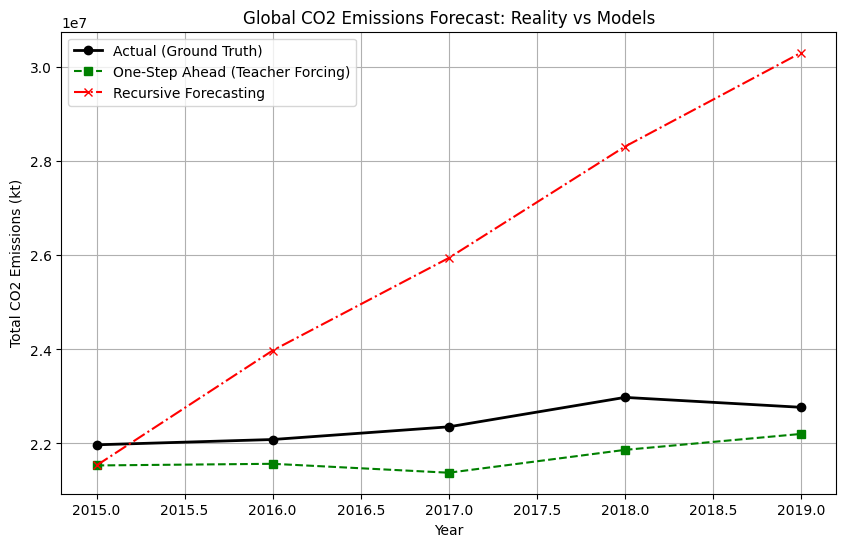

In [7]:
# Plot Global Trend Comparison (3 Lines)
# Aggregating by Year to show the global divergence
global_trends = results_df.groupby('Year')[['Actual', 'Teacher_Forcing_Pred', 'Recursive_Pred']].sum()

plt.figure(figsize=(10, 6))
plt.plot(global_trends.index, global_trends['Actual'], marker='o', label='Actual (Ground Truth)', color='black', linewidth=2)
plt.plot(global_trends.index, global_trends['Teacher_Forcing_Pred'], marker='s', linestyle='--', label='One-Step Ahead (Teacher Forcing)', color='green')
plt.plot(global_trends.index, global_trends['Recursive_Pred'], marker='x', linestyle='-.', label='Recursive Forecasting', color='red')

plt.title('Global CO2 Emissions Forecast: Reality vs Models')
plt.ylabel('Total CO2 Emissions (kt)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/recursive_comparison_plot.png')
print("Plot saved to ../reports/figures/recursive_comparison_plot.png")